In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [18]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [19]:
df = df.dropna(subset=['description', 'points'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


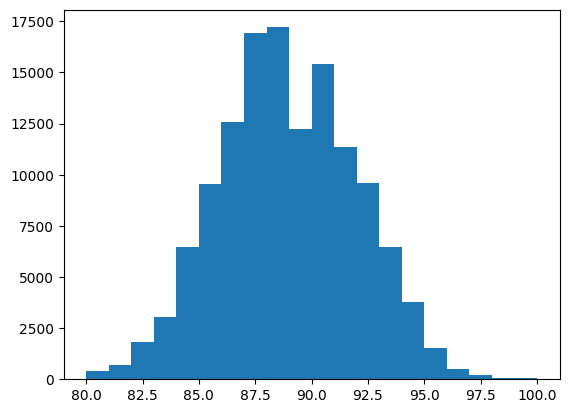

In [20]:
plt.hist(df.points, bins=20)
plt.show()

In [21]:
df["label"] = (df.points>=90).astype(int)
df = df[["description", "label"]]

In [22]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [23]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop("label")
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [24]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0]

embedig + model

In [26]:
embeding = "https://tfhub.dev/google/nnlm-ko-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(embeding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

In [35]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [29]:
model.evaluate(train_data)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


102/102 [==============================] - 5s 17ms/step - loss: 0.7963 - accuracy: 0.3766


[0.7963086366653442, 0.37663498520851135]

In [37]:
model.evaluate(valid_data)

13/13 [==============================] - 2s 142ms/step - loss: 0.7036 - accuracy: 0.4688


[0.7035810351371765, 0.46880048513412476]

In [38]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 110s 1s/step - loss: 0.5885 - accuracy: 0.6900 - val_loss: 0.4209 - val_accuracy: 0.8300
Epoch 2/5
102/102 [==============================] - 105s 1s/step - loss: 0.4098 - accuracy: 0.8322 - val_loss: 0.3600 - val_accuracy: 0.8407
Epoch 3/5
102/102 [==============================] - 110s 1s/step - loss: 0.3559 - accuracy: 0.8567 - val_loss: 0.3557 - val_accuracy: 0.8417
Epoch 4/5
102/102 [==============================] - 110s 1s/step - loss: 0.3285 - accuracy: 0.8694 - val_loss: 0.3571 - val_accuracy: 0.8411
Epoch 5/5
102/102 [==============================] - 110s 1s/step - loss: 0.3150 - accuracy: 0.8755 - val_loss: 0.3614 - val_accuracy: 0.8409


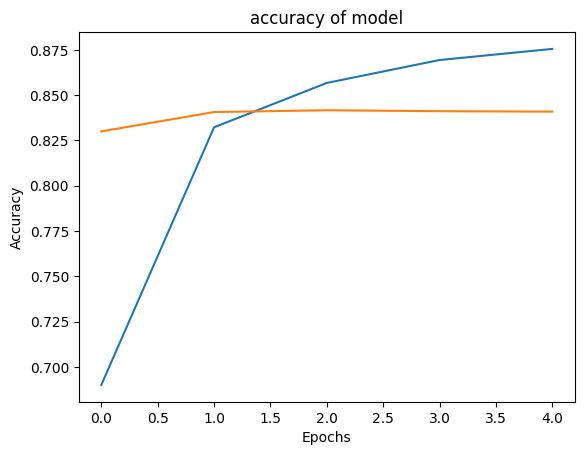

In [39]:
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend
plt.show()


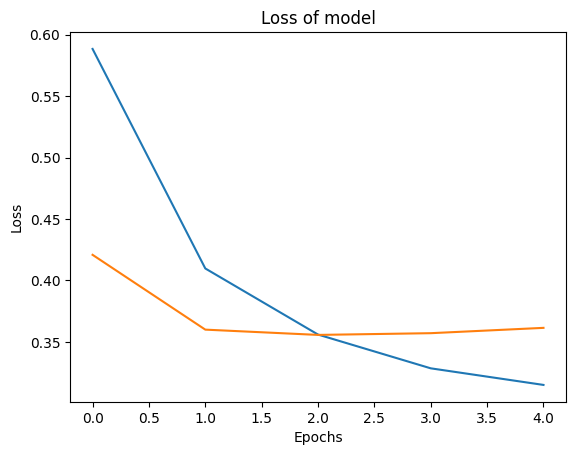

In [40]:
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend
plt.show()


LSTM

In [42]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [43]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [44]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

In [46]:
history2 = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 37s 310ms/step - loss: 0.5572 - accuracy: 0.7032 - val_loss: 0.3890 - val_accuracy: 0.8213
Epoch 2/5
102/102 [==============================] - 30s 296ms/step - loss: 0.3718 - accuracy: 0.8347 - val_loss: 0.3520 - val_accuracy: 0.8400
Epoch 3/5
102/102 [==============================] - 30s 296ms/step - loss: 0.3515 - accuracy: 0.8433 - val_loss: 0.3477 - val_accuracy: 0.8413
Epoch 4/5
102/102 [==============================] - 30s 295ms/step - loss: 0.3439 - accuracy: 0.8471 - val_loss: 0.3469 - val_accuracy: 0.8424
Epoch 5/5
102/102 [==============================] - 31s 301ms/step - loss: 0.3404 - accuracy: 0.8489 - val_loss: 0.3480 - val_accuracy: 0.8411


In [47]:
model.evaluate(test_data)

13/13 [==============================] - 3s 210ms/step - loss: 0.3584 - accuracy: 0.8351


[0.35844558477401733, 0.8350515365600586]